In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn import svm
import numpy as np

In [2]:
df = pd.read_csv('Chicago-Crimes-2017-2019.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)
df_socio = pd.read_csv('Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv');
df.shape

(610493, 22)

In [3]:
#Convert date column type to pandas datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')

#EXtract date only from date
df['date_only'] = df['date'].dt.date

#Get community area name from socio economy dataset
df = df.join(df_socio[['Community Area Number', 'COMMUNITY AREA NAME']].set_index('Community Area Number'), on="community_area")
df = df.rename(index=str, columns={"COMMUNITY AREA NAME": "community_area_name"})

In [4]:
# remove district 31 data as it's invalid
df_district_31 = df[df['district'] == 31]
df.drop(index = df_district_31.index, inplace=True)

# remove community area 0 as it's invalid
df_comm_area_0 = df[df['community_area'] == 0]
df.drop(index = df_comm_area_0.index, inplace=True)

In [5]:
df.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,date_only,community_area_name
0,False,811,063XX S ARCHER AVE,JC244019,56.0,2019-04-28 23:55:00,NON-AGGRAVATED,8.0,False,02,...,APARTMENT,-87.778802,CRIM SEXUAL ASSAULT,2019-05-05T16:05:28.000,23.0,1135466.0,1867706.0,2019,2019-04-28,Garfield Ridge
1,False,222,016XX E HYDE PARK BLVD,JC242207,39.0,2019-04-28 23:54:00,VIOLATE ORDER OF PROTECTION,2.0,True,26,...,RESIDENCE,-87.586041,OTHER OFFENSE,2019-05-05T16:05:28.000,5.0,1188001.0,1871507.0,2019,2019-04-28,Kenwood
2,False,511,002XX W 103RD ST,JC242231,49.0,2019-04-28 23:53:00,ARMED: HANDGUN,5.0,False,03,...,GAS STATION,-87.628834,ROBBERY,2019-05-05T16:05:28.000,9.0,1176618.0,1836644.0,2019,2019-04-28,Roseland
3,True,2513,016XX N MC VICKER AVE,JC242213,25.0,2019-04-28 23:46:00,DOMESTIC BATTERY SIMPLE,25.0,True,08B,...,APARTMENT,-87.776463,BATTERY,2019-05-05T16:05:28.000,29.0,1135828.0,1910278.0,2019,2019-04-28,Austin
4,False,2523,028XX N LOWELL AVE,JC242206,20.0,2019-04-28 23:45:00,TO VEHICLE,25.0,False,14,...,STREET,-87.735592,CRIMINAL DAMAGE,2019-05-05T16:05:28.000,31.0,1146896.0,1918517.0,2019,2019-04-28,Hermosa


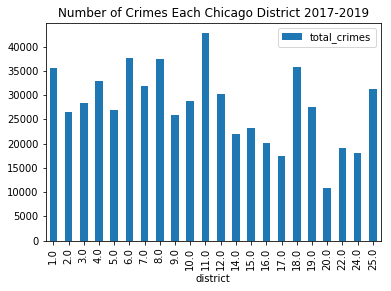

In [6]:
# Plot number of crime incidents all districts
df_count_district = df['district'].value_counts().to_frame()
df_count_district.columns = ['total_crimes']
df_count_district['district'] = df_count_district.index
df_count_district.sort_values(by=['district'], ascending=True, inplace=True)
df_count_district.plot(kind='bar', y='total_crimes', x='district', title='Number of Crimes Each Chicago District 2017-2019')

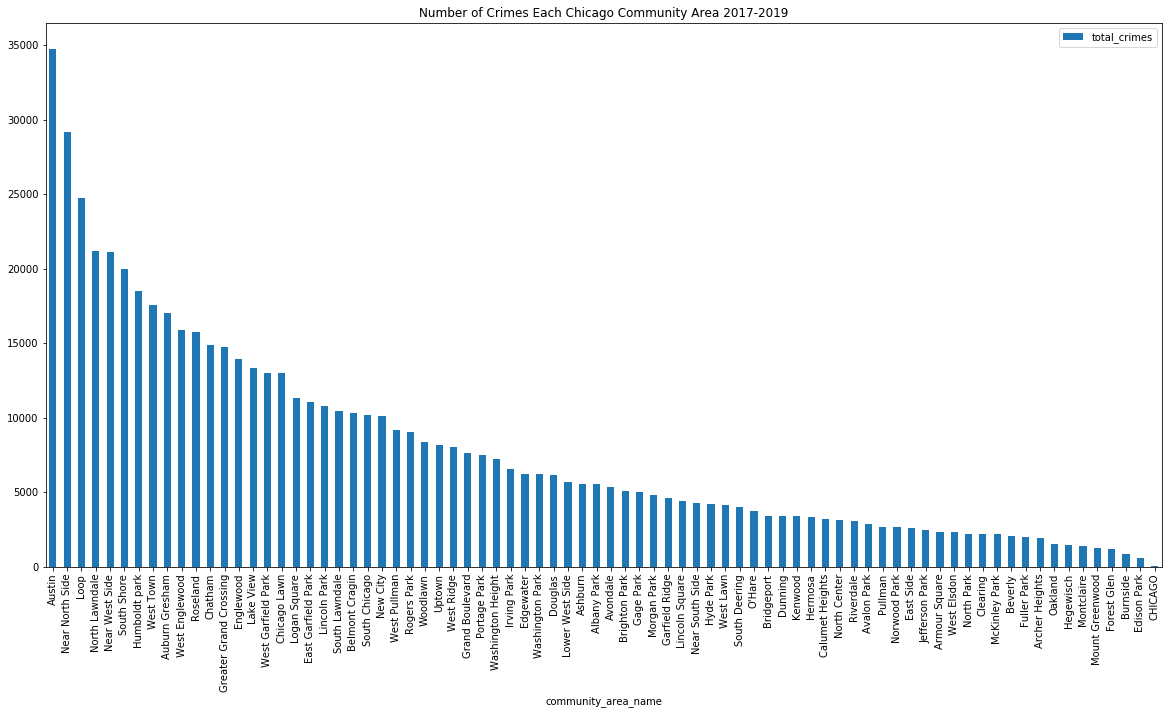

In [8]:
# Plot number of crime incidents in all community areas
df_count_community_area = df['community_area_name'].value_counts().to_frame()
df_count_community_area.columns = ['total_crimes']
df_count_community_area['community_area_name'] = df_count_community_area.index
#df_count_community_area.sort_values(by=['Community Area'], ascending=True, inplace=True)
df_count_community_area.plot(kind='bar', y='total_crimes', x='community_area_name', \
                             figsize=(20,10), \
                             title='Number of Crimes Each Chicago Community Area 2017-2019')

In [7]:
# Remove data without coordinates
df_without_coords = df[df[['latitude', 'longitude']].isna().all(1)]
df.drop(index=df_without_coords.index, inplace=True)

In [8]:
# Extract hour and day of week from date
df['hour'] = pd.to_numeric(df['date'].dt.hour)
df['day_of_week'] = df['date'].dt.dayofweek

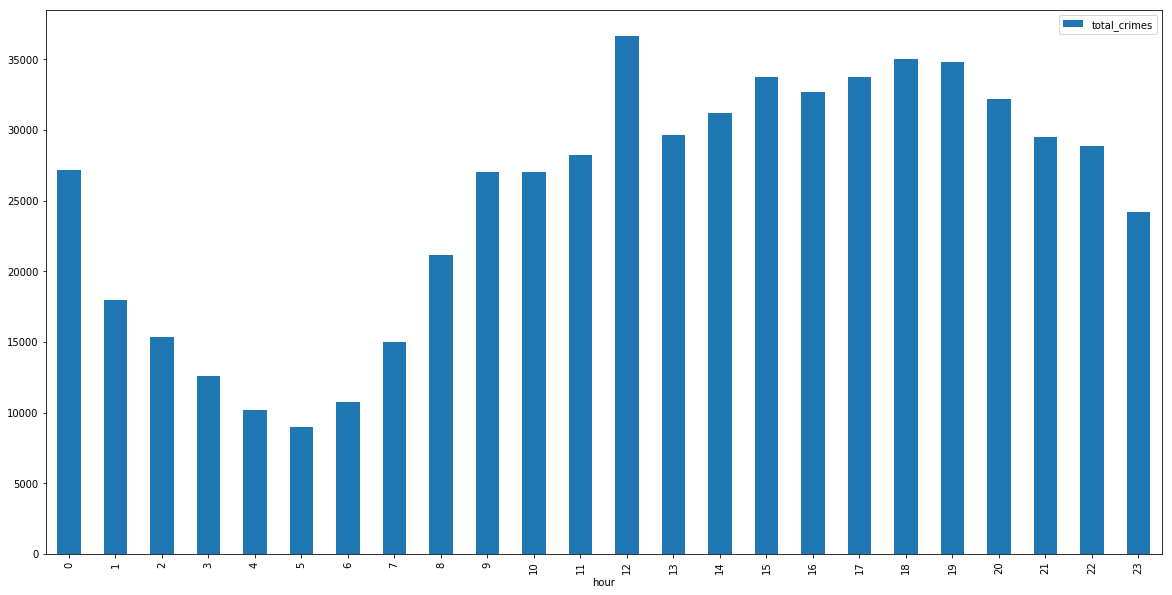

In [9]:
# Plot number of crime incidents all hours
df_count_hour = df['hour'].value_counts().to_frame()
df_count_hour.columns = ['total_crimes']
df_count_hour['hour'] = df_count_hour.index
df_count_hour.sort_values(by=['hour'], ascending=True, inplace=True)
df_count_hour.plot(kind='bar', y='total_crimes', x='hour', \
                             figsize=(20,10))

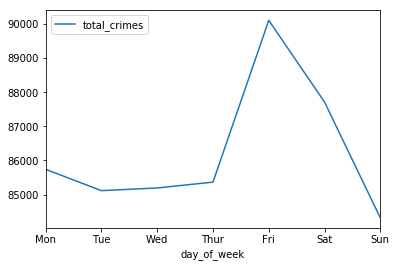

In [10]:
# Plot number of crime incidents all days of week
def set_day_name(day_of_week):
    if day_of_week == 0:
        return 'Mon'
    if day_of_week == 1:
        return 'Tue'
    if day_of_week == 2:
        return 'Wed'
    if day_of_week == 3:
        return 'Thur'
    if day_of_week == 4:
        return 'Fri'
    if day_of_week == 5:
        return 'Sat'
    if day_of_week == 6:
        return 'Sun'

df_count_day = df['day_of_week'].value_counts().to_frame()
df_count_day.columns = ['total_crimes']
df_count_day['day_of_week'] = df_count_day.index
df_count_day.sort_values(by=['day_of_week'], ascending=True, inplace=True)
df_count_day['day_of_week'] = df_count_day['day_of_week'].apply(set_day_name)
df_count_day.plot(kind='line', y='total_crimes', x='day_of_week')

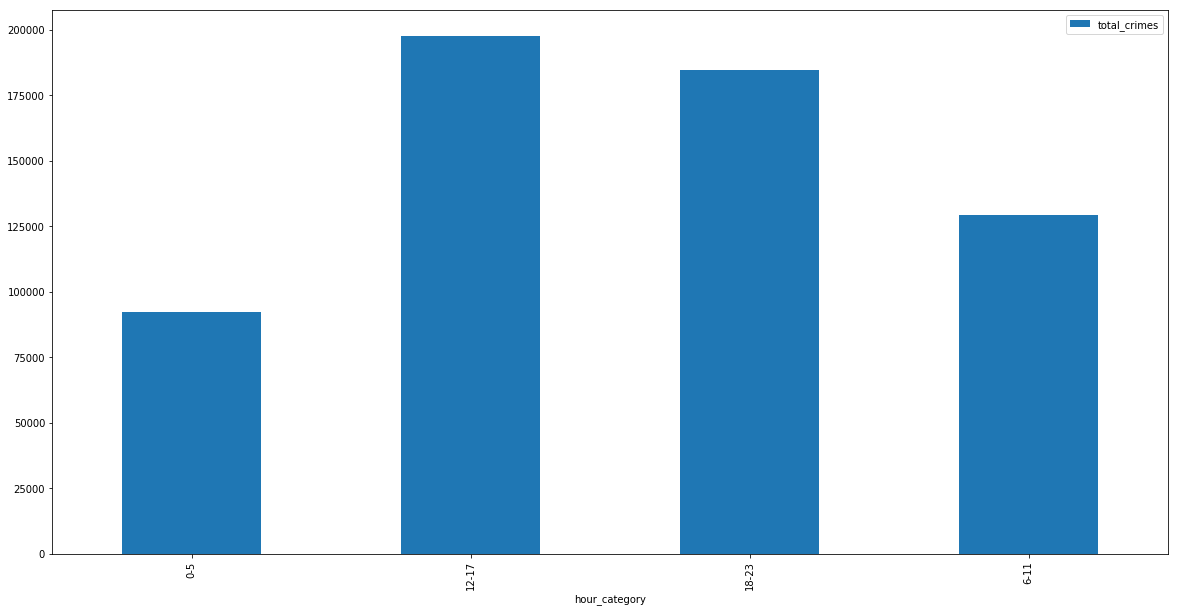

In [11]:
# Plot number of crime incidents all hour categories
def hour_category(hour) :
    if(hour >= 0 and hour <= 5):
        return '0-5'
    elif(hour >= 6 and hour <= 11):
        return '6-11'
    elif(hour >= 12 and hour <= 17):
        return '12-17'
    elif(hour >= 18 and hour <= 23):
        return '18-23'

df['hour_category'] = df['hour'].apply(hour_category)

df_count_hour = df['hour_category'].value_counts().to_frame()
df_count_hour.columns = ['total_crimes']
df_count_hour['hour_category'] = df_count_hour.index
df_count_hour.sort_values(by=['hour_category'], ascending=True, inplace=True)
df_count_hour.plot(kind='bar', y='total_crimes', x='hour_category', \
                             figsize=(20,10))

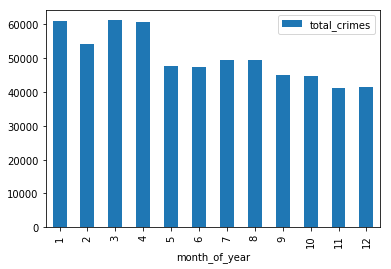

In [12]:
# Plot number of crime incidents all months of the year
df['month_of_year'] = df['date'].dt.month
df_count_month = df['month_of_year'].value_counts().to_frame()
df_count_month.columns = ['total_crimes']
df_count_month['month_of_year'] = df_count_month.index
df_count_month.sort_values(by=['month_of_year'], ascending=True, inplace=True)
df_count_month.plot(kind='bar', y='total_crimes', x='month_of_year')

# Build a Machine Learning Model

In [14]:
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LinearRegression, SGDRegressor)
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR
from sklearn import svm
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor

In [13]:
model_data = df.groupby(['date_only', 'day_of_week', 'hour_category', 'district', 'community_area_name'])['case_number'].count().reset_index()
model_data = pd.get_dummies(model_data, columns=['hour_category', 'day_of_week', 'district', 'community_area_name'])
model_data['case_number'].describe()

count    229564.000000
mean          2.629101
std           2.316935
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          81.000000
Name: case_number, dtype: float64

In [15]:
# Construct feature variables
X_columns = pd.Index([])

hour_category_columns = [col for col in model_data if col.startswith('hour_category')]
day_of_week_columns = [col for col in model_data if col.startswith('day_of_week')]
community_area_name_columns = [col for col in model_data if col.startswith('community_area_name')]
district_columns = [col for col in model_data if col.startswith('district')]

X_columns = X_columns.append(pd.Index(hour_category_columns))
X_columns = X_columns.append(pd.Index(day_of_week_columns))
X_columns = X_columns.append(pd.Index(community_area_name_columns))
X_columns = X_columns.append(pd.Index(district_columns))
X_data = model_data[X_columns]
X_data.shape

(229564, 111)

In [16]:
# Construct target variable
y_data = model_data['case_number']
y_data.shape

(229564,)

In [17]:
# Split train data (70%) and test data (30%)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data.values, test_size=0.3, random_state=42)

## Regression Model

In [18]:
# Compare the performance of models
estimators = [('LinearSVR', LinearSVR(random_state=42)),
              ('KNN Regressor', KNeighborsRegressor(n_neighbors=5)),
              ('SGDRegressor', SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)),
              ('ElasticNet', ElasticNet(random_state=42, alpha=0.5))]

for name, estimator in estimators:
    model = estimator
    model.fit(X_train, y_train)
    rmse = sqrt(mean_squared_error(model.predict(X_test), y_test))
    print("Name: ", name)
    print("RMSE: ", rmse)

Name:  LinearSVR
RMSE:  1.8296860286082628
Name:  KNN Regressor
RMSE:  1.6888178428721579
Name:  SGDRegressor
RMSE:  1.7674171386540578
Name:  ElasticNet
RMSE:  2.3107326749953936


In [19]:
model = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)
model.fit(X_data, y_data)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

### Predict the Highest Crime Rate Community Area Each District and Common Nearby Venues

In [24]:
LIMIT = 100
CLIENT_ID = 'Client ID' # your Foursquare ID
CLIENT_SECRET = 'Secret ID' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def getNearbyVenues(names, latitudes, longitudes, radius=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        
        if not results :
            print('empty !')
            continue
        
        results = results['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['case_number', 
                  'Incident Latitude', 
                  'Incident Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Your credentails:
CLIENT_ID: Client ID
CLIENT_SECRET:Secret ID


In [21]:
incident_merged = pd.DataFrame()
def predict(date, hour_category):
    print('Prediction of incidents number for each community area, date:', date, ', hour:', hour_category)
    df_grouped = df.groupby(['district', 'community_area_name'])['case_number'].count().reset_index()
    districts = df_grouped['district'].unique()
    day_of_week = pd.to_datetime(date).dayofweek
    for district in districts :
        areas = df_grouped[df_grouped['district'] == district]['community_area_name'].unique()
        
        print('District: ', int(district))
        max_pred = 0
        area_max_rate = ''
        for area in areas :
            data = np.zeros((1, len(X_columns)))
            X_features = pd.DataFrame(data, columns=X_columns, index=[0])
            X_features.iloc[0]['day_of_week_' + str(day_of_week)] = 1
            X_features.iloc[0]['community_area_name_' + area] = 1
            X_features.iloc[0]['hour_category_'+hour_category] = 1     
            y_pred = model.predict(X_features)[0]
            
            district_comm_area_incidents = df[(df['district'] == district) & \
                                          (df['community_area_name'] == area) & \
                                          (df['day_of_week']==day_of_week) & \
                                          (df['hour_category']==hour_category)]
            
            if len(district_comm_area_incidents.index) == 0:
                temp_df = df[(df['district'] == district) & \
                                          (df['community_area_name'] == area) & \
                                          (df['hour_category']==hour_category)].groupby('date_only')['case_number'].count().reset_index()
                y_pred = temp_df['case_number'].mean()
                if len(temp_df.index) == 0:
                    y_pred = 0
            
            if y_pred > max_pred:
                max_pred = y_pred
                area_max_rate = area
                
            print('---Community Area: ' + area + ", predicted number of incident : " + str(y_pred))            
        
        
        print('Predicted community area with highest incident number : ' + area_max_rate + ', with number of incidents: ' + str(int(round(max_pred))))
        district_comm_area_incidents = df[(df['district'] == district) & \
                                          (df['community_area_name'] == area_max_rate) & \
                                          (df['day_of_week']==day_of_week) & \
                                          (df['hour_category']==hour_category)]
        
        incident_venues = getNearbyVenues(names=district_comm_area_incidents['case_number'].tail(50),
                                         latitudes=district_comm_area_incidents['latitude'].tail(50),
                                         longitudes=district_comm_area_incidents['longitude'].tail(50))
        
        incident_venues = pd.get_dummies(incident_venues[['case_number', 'Venue Category']], columns=['Venue Category'], prefix="", prefix_sep="")
        incident_merged = pd.merge(district_comm_area_incidents[['case_number', 'district', 'community_area_name', 'day_of_week', 'hour_category']], \
                                   incident_venues, on='case_number', how='outer')
        incident_merged = incident_merged.groupby(['district', 'community_area_name', 'day_of_week', 'hour_category']).mean().reset_index();
        
        # Print top 5 most common places
        num_top_venues = 5

        print("Top 5 common nearby venues (radius 100 metres)")
        temp = incident_merged.T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[4:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        
        
        print('\n')

In [22]:
# Hour Category options : 0-5, 6-11, 12-17, 18-23

# Friday evening
predict('2019-05-10', '18-23')

Prediction of incidents number for each community area, date: 2019-05-10 , hour: 18-23
District:  1
---Community Area: Armour Square, predicted number of incident : 2.3235137810103677
---Community Area: Douglas, predicted number of incident : 2.5395488840941756
---Community Area: East Garfield Park, predicted number of incident : 0
---Community Area: Loop, predicted number of incident : 8.855660551750738
---Community Area: Near South Side, predicted number of incident : 3.156256121354368
---Community Area: Near West Side, predicted number of incident : 3.710297850544273
Predicted community area with highest incident number : Loop, with number of incidents: 9
Top 5 common nearby venues (radius 100 metres)
                venue  freq
0               Hotel  0.08
1         Coffee Shop  0.07
2      Sandwich Place  0.06
3  Italian Restaurant  0.03
4  Seafood Restaurant  0.03




District:  2
---Community Area: Armour Square, predicted number of incident : 1.0
---Community Area: Douglas, pred